<a href="https://colab.research.google.com/github/sophieruss/587/blob/main/CSC587_Final_Project(ResNet50_Custom).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Doctors’ Handwritten Prescription Recognition
The aim is to create a robust classifier to demystify short-form writing systems and accurately identify written prescriptions. This project addresses a critical challenge in the healthcare sector, in which inconsistent handwriting, shorthand, and text segmentation often create risks for patient safety and pharmacy errors. By creating a machine learning model that can effectively recognize and classify medical prescriptions, we seek to improve patient care by minimizing medication errors.

To determine the most effective model architectures for this task, we will implement and compare several pre-trained and custom models. Our goal is to explore how model complexity, transfer learning, and custom feature engineering influence performance when handling noisy, real-world handwritten medical data. This investigation will provide valuable insights into which techniques best address the unique challenges posed by prescription recognition.


In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 687.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.optimizers import SGD, Adam

from matplotlib import pyplot as plt

# Get labels for training data
raw_csv_url_train = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Training/training_labels.csv"
df_train = pd.read_csv(raw_csv_url_train)
print(df_train.head(20))

# Get labels for testing data
raw_csv_url_test = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Testing/testing_labels.csv"
df_test = pd.read_csv(raw_csv_url_test)
print(df_test.head(20))

# Get labels for validation data
raw_csv_url_val = "https://raw.githubusercontent.com/cjerryc/Prescription-Handwriting-Identification/refs/heads/main/Data/Validation/validation_labels.csv"
df_val = pd.read_csv(raw_csv_url_val)
print(df_val.head(20))

     IMAGE MEDICINE_NAME GENERIC_NAME
0    0.png         Aceta  Paracetamol
1    1.png         Aceta  Paracetamol
2    2.png         Aceta  Paracetamol
3    3.png         Aceta  Paracetamol
4    4.png         Aceta  Paracetamol
5    5.png         Aceta  Paracetamol
6    6.png         Aceta  Paracetamol
7    7.png         Aceta  Paracetamol
8    8.png         Aceta  Paracetamol
9    9.png         Aceta  Paracetamol
10  10.png         Aceta  Paracetamol
11  11.png         Aceta  Paracetamol
12  12.png         Aceta  Paracetamol
13  13.png         Aceta  Paracetamol
14  14.png         Aceta  Paracetamol
15  15.png         Aceta  Paracetamol
16  16.png         Aceta  Paracetamol
17  17.png         Aceta  Paracetamol
18  18.png         Aceta  Paracetamol
19  19.png         Aceta  Paracetamol
     IMAGE MEDICINE_NAME GENERIC_NAME
0    0.png         Aceta  Paracetamol
1    1.png         Aceta  Paracetamol
2    2.png         Aceta  Paracetamol
3    3.png         Aceta  Paracetamol
4    4.png  

#### View some of the Training data.
Observe the labels and the bins of handwritten medications (78 types).

In [ ]:
df_train[df_train["IMAGE"] == '600.png']

,IMAGE,MEDICINE_NAME,GENERIC_NAME
600,600.png,Bicozin,Vitamin B Complex + Zinc


In [3]:
change_indices = df_train.index[df_train['MEDICINE_NAME'].ne(df_train['MEDICINE_NAME'].shift())].to_list()

# Create ranges
ranges = []
for i in range(len(change_indices)):
    start = change_indices[i]
    end = change_indices[i + 1] if i + 1 < len(change_indices) else len(df_train)
    group_name = df_train['MEDICINE_NAME'].iloc[start]
    ranges.append((group_name, (start, end)))

print(ranges)


[('Aceta', (0, 40)), ('Ace', (40, 80)), ('Alatrol', (80, 120)), ('Amodis', (120, 160)), ('Atrizin', (160, 200)), ('Axodin', (200, 240)), ('Azithrocin', (240, 280)), ('Azyth', (280, 320)), ('Az', (320, 360)), ('Bacaid', (360, 400)), ('Backtone', (400, 440)), ('Baclofen', (440, 480)), ('Baclon', (480, 520)), ('Bacmax', (520, 560)), ('Beklo', (560, 600)), ('Bicozin', (600, 640)), ('Canazole', (640, 680)), ('Candinil', (680, 720)), ('Cetisoft', (720, 760)), ('Conaz', (760, 800)), ('Dancel', (800, 840)), ('Denixil', (840, 880)), ('Diflu', (880, 920)), ('Dinafex', (920, 960)), ('Disopan', (960, 1000)), ('Esonix', (1000, 1040)), ('Esoral', (1040, 1080)), ('Etizin', (1080, 1120)), ('Exium', (1120, 1160)), ('Fenadin', (1160, 1200)), ('Fexofast', (1200, 1240)), ('Fexo', (1240, 1280)), ('Filmet', (1280, 1320)), ('Fixal', (1320, 1360)), ('Flamyd', (1360, 1400)), ('Flexibac', (1400, 1440)), ('Flexilax', (1440, 1480)), ('Flugal', (1480, 1520)), ('Ketocon', (1520, 1560)), ('Ketoral', (1560, 1600)), (

In [ ]:
# df_train["MEDICINE_NAME"].nunique()
df_test["MEDICINE_NAME"].nunique()

78

#### Get the Handwritten Medication Images

In [4]:
import tensorflow as tf

# Clone the entire GitHub repository
!git clone https://github.com/cjerryc/Prescription-Handwriting-Identification.git

# Navigate to the Training image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Training/training_words
dataset_path_train = "/content/Prescription-Handwriting-Identification/Data/Training/"

# Navigate to the Testing image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Testing/testing_words
dataset_path_test = "/content/Prescription-Handwriting-Identification/Data/Testing/"

# Navigate to the Validation image folder
# https://github.com/cjerryc/Prescription-Handwriting-Identification/tree/main/Data/Validation/validation_words
dataset_path_val = "/content/Prescription-Handwriting-Identification/Data/Validation/"


# Parameters
img_size = (100, 250)  # or whatever your CNN expects
batch_size = 32

# Load Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_train,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
training_images = np.concatenate([x.numpy() for x in train_ds], axis=0)
training_images = (training_images.astype('float32') / 255) * 2 - 1

# Load Testing dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_test,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
testing_images = np.concatenate([x.numpy() for x in test_ds], axis=0)
testing_images = (testing_images.astype('float32') / 255) * 2 - 1

# Load Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_val,
    label_mode= None,
    # color_mode = "grayscale",
    # batch_size= None,
    image_size=img_size,
    shuffle=False,
)
validation_images = np.concatenate([x.numpy() for x in val_ds], axis=0)
validation_images = (validation_images.astype('float32') / 255) * 2 - 1

Cloning into 'Prescription-Handwriting-Identification'...
remote: Enumerating objects: 4437, done.
remote: Counting objects: 100% (4437/4437), done.
remote: Compressing objects: 100% (4404/4404), done.
remote: Total 4437 (delta 32), reused 4434 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (4437/4437), 16.85 MiB | 41.47 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Found 3120 files.
Found 780 files.
Found 780 files.


In [ ]:
# from PIL import Image
# import os

# # Get path to one sample image
# sample_path = os.path.join(dataset_path_train, os.listdir(dataset_path_train)[1])
# img = Image.open(sample_path+ "/2010.png")
# print(img.size)  # (width, height)

In [ ]:
testing_images.shape

(780, 100, 250, 3)

In [5]:
# Reshape to add the channel dimension (1 channel for grayscale images) for Conv2D layer, which  expects 4D input with the shape
# (batch_size, height, width, channels)
train_images = training_images.reshape((training_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
train_labels, uniques_train = pd.factorize(df_train['MEDICINE_NAME'])

test_images = testing_images.reshape((testing_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
test_labels, uniques_test = pd.factorize(df_test['MEDICINE_NAME'])

val_images = validation_images.reshape((validation_images.shape[0], 100, 250, 3))
# Map labels to an index number and store the mapping in 'uniques'
val_labels, uniques_val = pd.factorize(df_val['MEDICINE_NAME'])

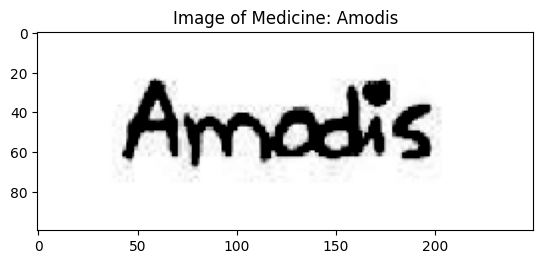

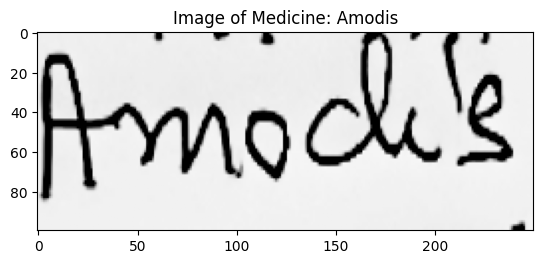

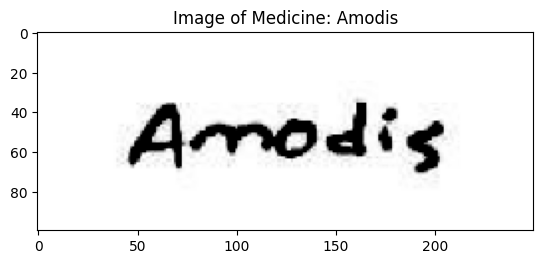

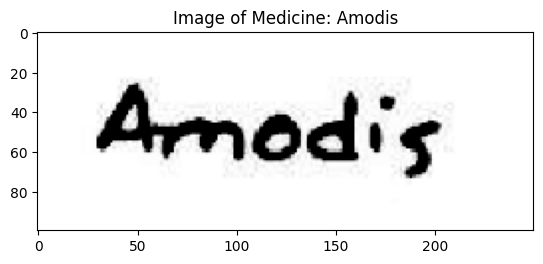

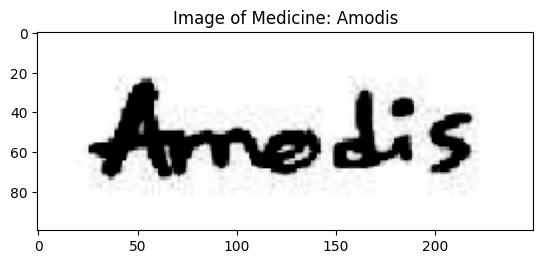

In [6]:
# Helper function to visualize images
def plot_img(x,y):
  plt.imshow(x)
  plt.title(f'Image of Medicine: {y}')
  plt.show()

for i in range(5):
  # plot_img(training_images[38+i], uniques_train[train_labels[38+i]])
  # plot_img(test_images[60+i], uniques_test[test_labels[60+i]])
  plot_img(val_images[30+i], uniques_val[val_labels[30+i]])

##1.2 Network Design
Convolutional neural networks are often appropriate for image processing tasks. The early
layers of the network consist of small convolutional filters which act like local feature detectors;
the later layers of the network aggregate the local feature responses into a global prediction.


A convolutional layer is parameterized by a filter matrix W and a bias vector b:


𝑧 = 𝜎(𝑊 ∗ 𝑥 + 𝑏)


where * indicates the convolution operation. The filter "slides" over the input image x and performs a dot product over a local window at each pixel in the image.


You will build a LeNet model which uses 5x5 convolutional filters and max pooling to downsample and aggregate filter responses.


We will modify the original design by adding an additional two-dimensional hidden layer before the final linear classifier to aid in visualizing the representation learned by the network.


The model should have the following architecture:
1. 2D convolution with 50 5x5 filters, 'valid' padding, ReLU activation
2. 2D max pooling with 2x2 window, stride of 2
3. 2D convolution with 20 5x5 filters, 'valid' padding, ReLU activation
4. 2D max pooling with 2x2 window, stride of 2
5. Flatten
6. Fully connected layer with 200 units, ReLU activation
7. Fully connected layer with 2 units, linear activation ("embedding" layer for visualization)
8. Fully connected layer with 10 units, softmax activation (output layer).


Compile the model to use the sparse categorical cross-entropy loss and the SGD optimizer with a learning rate of 0.01. Use a batch size of 100 over at least 20 epochs with a validation split of 0.1 during training. Feel free to tweak these parameters as you see fit.


Show the loss and accuracy curves you got with your best performing configuration. Evaluate your model on the training and test sets and describe its performance in terms of accuracy and overfitting.

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Save Checkpoint paths
lightweight_ckpt = '/tmp/ckpt/lightweight_best.model.keras'
lightweight_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=lightweight_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr = 0.01
batch_size = 50
epochs = 100

inputs = Input(shape=(100, 250, 3),name='input_layer')  # Input layer: 4-dimensional vector
hidden = inputs
hidden_layers = []

hidden = layers.RandomZoom(0.2)(hidden)
hidden = layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(hidden)
hidden = layers.RandomRotation(0.01)(hidden)

hidden = layers.Conv2D(50, 3, activation='leaky_relu', padding='same', name='conv1')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
# hidden = Dropout(0.05)(hidden)

hidden = layers.Conv2D(80, 3, activation='leaky_relu', padding='same', name='conv12')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
hidden = Dropout(0.01)(hidden)

hidden = layers.Conv2D(100, 3, activation='leaky_relu', padding='same', name='conv2')(hidden)
hidden = layers.MaxPooling2D(pool_size=(3,3), strides=2)(hidden)
hidden = Dropout(0.05)(hidden)

hidden = layers.Conv2D(200, 3, activation='leaky_relu', padding='same', name='conv3')(hidden)
hidden = layers.MaxPooling2D(pool_size=(2,2), strides=2)(hidden)
hidden = Dropout(0.05)(hidden)

hidden = layers.Flatten()(hidden)
hidden = layers.Dense(128, activation='leaky_relu', name='dense1')(hidden)
hidden = Dropout(0.05)(hidden)

embedding = layers.Dense(128, activation=None, name='embedding_for_vis')(hidden)
hidden_layers.append(embedding)
outputs = layers.Dense(78,activation='softmax',name='output')(embedding)

model = Model(inputs=inputs,outputs=outputs) # Model for end-to-end training
encoders = []
for l in hidden_layers:
  encoders.append(Model(inputs=inputs,outputs=l))

opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                    verbose=True,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
                    callbacks=[lightweight_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(lightweight_ckpt)

print(model.summary())

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.0125 - loss: 4.3639 - val_accuracy: 0.0179 - val_loss: 4.3482
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.0161 - loss: 4.3549 - val_accuracy: 0.0218 - val_loss: 4.3343
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.0205 - loss: 4.3419 - val_accuracy: 0.0269 - val_loss: 4.3155
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.0260 - loss: 4.3253 - val_accuracy: 0.0500 - val_loss: 4.2735
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.0335 - loss: 4.3008 - val_accuracy: 0.0397 - val_loss: 4.2081
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.0279 - loss: 4.2680 - val_accuracy: 0.0564 - val_loss: 4.1188
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.0289 - loss: 4.2304 - val_accuracy: 0.0538 - val_loss: 4.0475
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.0392 - loss: 4.1672 - val_accuracy: 0.

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
results = model.evaluate(test_images, test_labels,
                       verbose=False)
print('Final accuracy with TEST images and labels: ',results[1]*100)

In [ ]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
predictions

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


array([73, 76, 30, 12, 14, 24, 30, 30, 76, 30, 50, 48, 48, 56, 58, 50, 26,
        2, 41, 46, 42, 29,  3, 44, 29, 17, 32, 62, 37, 68, 30, 43,  6, 29,
       63, 65, 17, 28,  3, 65, 28, 37, 59, 59, 26, 26, 75, 17, 61, 16, 48,
       15, 48, 45, 15, 15, 45,  3, 45, 48, 29, 18, 14, 59, 69, 50, 22, 73,
       51, 29, 44,  2, 29,  3, 12, 29, 17,  2, 29, 14,  8, 62,  8,  8, 26,
       77,  8,  8,  8,  8,  2,  7, 19, 59,  9,  7, 29, 43, 29, 43, 68, 34,
       62, 73, 59, 59, 32,  7, 73, 34, 76, 69, 76, 15, 15, 50, 34, 48, 46,
       45, 16,  5, 54, 30, 22, 76, 30, 14, 50, 29, 76, 62, 41, 63, 26, 50,
       14, 17,  3, 34, 30, 24, 65,  7, 51,  3,  2, 73,  3, 65, 15, 73, 15,
       46, 16, 73, 15, 48, 15,  3, 44,  3,  7, 32, 15, 29, 68, 37, 14, 29,
       68,  3, 26, 41, 65, 68,  9, 17, 66, 29, 68, 68, 62, 65, 73, 17, 68,
       62, 29, 42, 29, 68, 51, 26,  2, 68, 29, 43, 19, 19, 37,  9, 37,  8,
       20, 18, 41, 37, 65, 23, 41,  8, 41, 41, 20, 37, 41, 41, 37, 18, 14,
       15, 14, 22,  6,  3

In [ ]:
incorrect_class_count = 0
for i in range(len(predictions)):
  if predictions[i] != test_labels[i]:
    print(i, predictions[i], test_labels[i])
    incorrect_class_count += 1
print(incorrect_class_count)


0 73 0
1 76 0
2 30 0
3 12 0
4 14 0
5 24 0
6 30 0
7 30 0
8 76 0
9 30 0
10 50 1
11 48 1
12 48 1
13 56 1
14 58 1
15 50 1
16 26 1
17 2 1
18 41 1
19 46 1
20 42 2
21 29 2
22 3 2
23 44 2
24 29 2
25 17 2
26 32 2
27 62 2
28 37 2
29 68 2
30 30 3
31 43 3
32 6 3
33 29 3
34 63 3
35 65 3
36 17 3
37 28 3
39 65 3
40 28 4
41 37 4
42 59 4
43 59 4
44 26 4
45 26 4
46 75 4
47 17 4
48 61 4
49 16 4
50 48 5
51 15 5
52 48 5
53 45 5
54 15 5
55 15 5
56 45 5
57 3 5
58 45 5
59 48 5
60 29 6
61 18 6
62 14 6
63 59 6
64 69 6
65 50 6
66 22 6
67 73 6
68 51 6
69 29 6
70 44 7
71 2 7
72 29 7
73 3 7
74 12 7
75 29 7
76 17 7
77 2 7
78 29 7
79 14 7
81 62 8
84 26 8
85 77 8
90 2 9
91 7 9
92 19 9
93 59 9
95 7 9
96 29 9
97 43 9
98 29 9
99 43 9
100 68 10
101 34 10
102 62 10
103 73 10
104 59 10
105 59 10
106 32 10
107 7 10
108 73 10
109 34 10
110 76 11
111 69 11
112 76 11
113 15 11
114 15 11
115 50 11
116 34 11
117 48 11
118 46 11
119 45 11
120 16 12
121 5 12
122 54 12
123 30 12
124 22 12
125 76 12
126 30 12
127 14 12
128 50 12
129 

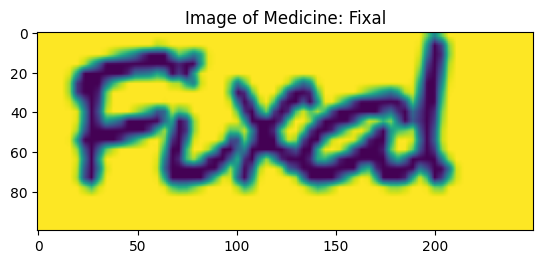

In [ ]:
plot_img(test_images[330], uniques_test[test_labels[330]])

In [ ]:
uniques_test[predictions[330]]

'Dancel'

ValueError: The number of FixedLocator locations (78), usually from a call to set_ticks, does not match the number of labels (2).

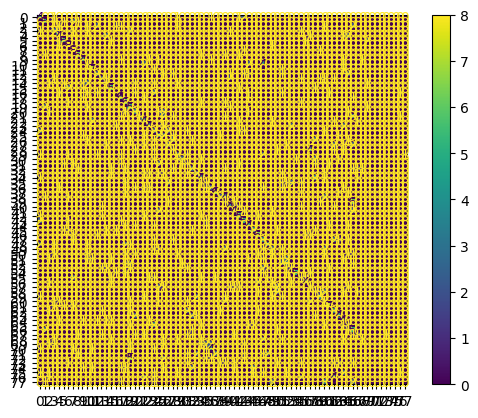

In [ ]:
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

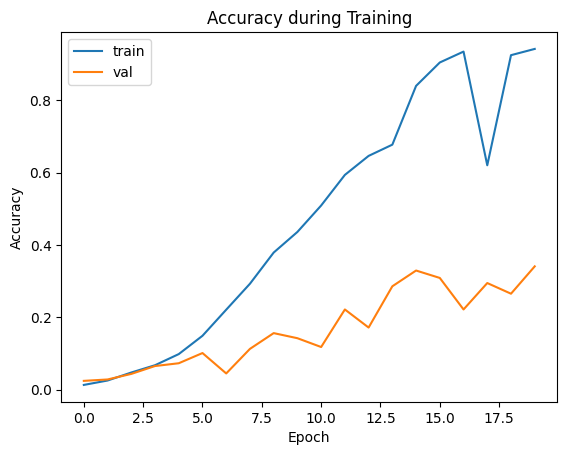

In [ ]:
def plot_history(history):
  plt.plot(history.history['accuracy'],label='train')
  if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'],label='val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Accuracy during Training')
  plt.show()

plot_history(history)

# RESNET 50

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

# # CUSTOM F1  ########################################################################
# class F1Score(tf.keras.metrics.Metric):
#     def __init__(self, name='f1_score', **kwargs):
#         super(F1Score, self).__init__(name=name, **kwargs)
#         self.precision = tf.keras.metrics.Precision()
#         self.recall = tf.keras.metrics.Recall()

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_pred_labels = tf.argmax(y_pred, axis=1)
#         y_true = tf.reshape(y_true, [-1])
#         self.precision.update_state(y_true, y_pred_labels, sample_weight)
#         self.recall.update_state(y_true, y_pred_labels, sample_weight)

#     def result(self):
#         p = self.precision.result()
#         r = self.recall.result()
#         return 2 * ((p * r) / (p + r + K.epsilon()))

#     def reset_states(self):
#         self.precision.reset_states()
#         self.recall.reset_states()
# # CUSTOM F1  ########################################################################

# Data augmentation block
data_augmentation = models.Sequential([
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomRotation(0.01),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
], name="data_augmentation")

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(100, 250, 3))
base_model.trainable = False  # Freeze pretrained layers


model = models.Sequential([
    # data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dropout(0.05),
    layers.Dense(78, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Tune this
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Save Checkpoint paths
head_ckpt = '/tmp/ckpt/head_best.model.keras'
head_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=head_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

EPOCH_NUM = 100
# Train Classifier
history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=EPOCH_NUM,
                    validation_data=(val_images, val_labels),
                    verbose=True,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
                    callbacks=[head_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(head_ckpt)





# Save Checkpoint paths
finetune_ckpt = '/tmp/ckpt/finetuned_best.model.keras'
finetune_model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=finetune_ckpt,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Fine-tune Deeper Layer
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-35]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),  # Tune this
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_images, train_labels,
          batch_size=batch_size,
          epochs=EPOCH_NUM,
          validation_data=(val_images, val_labels),
          verbose=True,
          # callbacks=[EarlyStopping(monitor='val_loss', patience=4)])
          callbacks=[finetune_model_checkpoint_callback])

# Load the best model
model = keras.models.load_model(finetune_ckpt)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - accuracy: 0.0093 - loss: 4.4219 - val_accuracy: 0.0282 - val_loss: 4.2743
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.0293 - loss: 4.2821 - val_accuracy: 0.0538 - val_loss: 4.1881
Epoch 3/100
37/98 ━━━━━━━━━━━━━━━━━━━━ 3:12 3s/step - accuracy: 0.0469 - loss: 4.2134

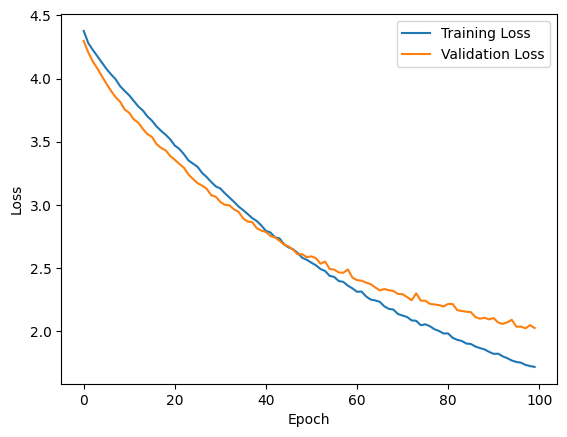

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

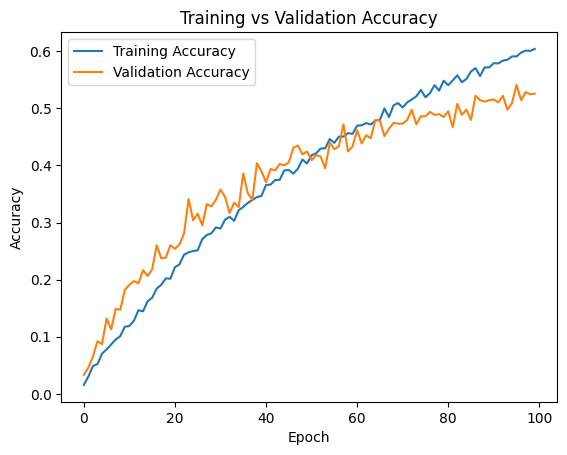

In [ ]:
# Plot training and validation accuracy from the training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
results = model.evaluate(test_images, test_labels,
                       verbose=False)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value:.4f}")
print('Final accuracy with TEST images and labels: ',results[1]*100)

Final accuracy with TEST images and labels:  61.538463830947876


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
y_pred = predictions
y_true = test_labels

precision = precision_score(y_true, y_pred, average='macro')  # or 'weighted' or 'micro'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Precision: 0.64661
Recall:    0.61538
F1 Score:  0.60547
